In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# 3d plot with group ratio and group offset and error
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

In [2]:

def simulate_no_courses(no_courses, no_students, no_simulations, group_size = [x/500 for x in range(1, 70, 10)], group_offset = [(x, y) for x in np.arange(-2, 0, 1) for y in np.arange(1, 3, 1)], interpolation='linear', verbose=False, offset= True):

    group_ratio = 0.5

    # DCF course 
    dcf = 0

    
    # Group offsets
    

    #sim_err = []
    global_sim_err = []
    global_err = []
    global_intercepts = []
    power_offset = []
    for g_size in group_size:
        errors = []
        intercepts = []
        sim_err = []
        power_list = []
        for offset in group_offset:
            power = 0
            current_sim_err = []
            for sim in range(no_simulations):
                # split students into two groups based on group ratio
                no_students = g_size * group_ratio + (1 - group_ratio) * g_size
                no_students = int(no_students)
                # Generate IRT parameters
                theta = np.random.normal(0, 1, no_students)
                d = np.random.normal(0, 1, no_courses)
                d = d.reshape((no_courses, 1))

                # Generate student responses
                p = 1 / (1 + np.exp(-(theta - d)))
                y = np.random.binomial(1, p)
                group1 = np.random.choice(np.arange(0, no_students), int(g_size), replace=False)#no_students*group_ratio)
                group2 = np.setdiff1d(np.arange(0, no_students), group1)

                y_new = y.copy()

                # calculate new responses for the dcf course
                p_1 = 1 / (1 + np.exp(-(theta[group1] - d[dcf] + offset[0])))
                p_2 = 1 / (1 + np.exp(-(theta[group2] - d[dcf] + offset[1])))

                y_new[dcf, group1] = np.random.binomial(1, p_1)
                y_new[dcf, group2] = np.random.binomial(1, p_2)

                # fit the logistic regression model for dcf
                from statsmodels.formula.api import glm
                import statsmodels.api as sm
                group_name = [-1 if x in group1 else 1 for x in range(0, no_students)]
                difficulty = [d[dcf][0] for x in range(0, no_students)]
                data = pd.DataFrame({'y': y_new[dcf], 'theta': theta, 'group': group_name, 'difficulty': difficulty})

                reg_form = 'y ~ group + 1'
                if offset:
                    offset_data = data['theta'] - data['difficulty'] 
                else:
                    offset_data = np.zeros(no_students)
                model = glm(reg_form, data=data, family=sm.families.Binomial(), offset=offset_data)
                # get the p value of the group coefficient
                p_value = model.fit().pvalues[1]
     
                if p_value < 0.05:
                    power += 1
                intercept = model.fit().params[0]
                group = model.fit().params[1]
                p_pred_1 = 1 / (1 + np.exp(-(theta[group1] - d[dcf][0] + intercept - group))) 
                p_pred_2 = 1 / (1 + np.exp(-(theta[group2] - d[dcf][0] + intercept + group)))   
                err = np.mean(np.mean(np.abs(p_pred_1 - p_1)) + np.mean(np.abs(p_pred_2 - p_2)))
                

                
                current_sim_err.append(err)
            power = power / no_simulations
            power_list.append(power)
            errors.append(err)
            intercepts.append(intercept)
                # if verbose:
            #     plt.figure(figsize=(5, 2))
            #     plt.scatter(theta[group2], p_2, alpha=1, marker='.', s=2, label= '1')
            #     plt.scatter(theta[group2], p_pred_2, alpha=1, marker='.', s=2, label= '1 recovered')
            #     plt.scatter(theta, p[dcf], alpha=1, marker='.', s=1, label='rasch')
            #     plt.scatter(theta[group1], p_1, alpha=1, marker='.', s=2, label = '-1')
            #     plt.scatter(theta[group1], p_pred_1, alpha=1, marker='.', s=2, label = '-1 recovered')
            #     plt.xlabel('Theta')
            #     plt.ylabel('Proportion Correct')
            #     plt.title('Error: ' + str(round(err, 2)))
            #     # set font size
            #     plt.rcParams.update({'font.size': 10})
            #     plt.legend()
            #     plt.show()
            sim_err.append((np.mean(current_sim_err), np.std(current_sim_err)))
        power_offset.append(power_list)
        global_err.append(errors)
        global_intercepts.append(intercepts)
        global_sim_err.append(sim_err)
    global_err = np.array(global_err)


    if verbose:
        plt.rcParams.update({'font.size': 10})

        # 3D plot
        fig = plt.figure(figsize=(15, 6))
        



            
        print(group_size, power_offset)
        print(np.array(power_offset).shape)
        
        # get global sim errors per group
        global_sim_err = np.array(global_sim_err)
        print(global_sim_err.shape)
        # 14~ group sizes, 6~ group offsets 
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        ax3 = fig.add_subplot(121)
        ax4 = fig.add_subplot(122)
        for i, offset in enumerate(group_offset):
            sim_means = global_sim_err[:,i,0]    
            sim_std = global_sim_err[:,i,1]
            ax3.errorbar(group_size, sim_means, yerr= 1.96*sim_std , label='$ß_1$: ' + str(np.round(abs(offset[0]),2)), alpha=0.5, color = colors[i], marker='o')

            # plot the power curve for each offset and show the power as a second y axis
            
            ax4.plot(group_size, np.array(power_offset)[:,i], alpha=0.5, label = '$ß_1$: ' + str(np.round(abs(offset[0]),2)), color = colors[i], marker='o')
 
            #ax3.plot(group_size, np.array(power_offset)[:,i], alpha=0.5, label = 'Power: ' + str(np.round(abs(offset[0]),2)))
        ax3.set_xlabel('Group Size')
        ax3.set_ylabel('Global Mean Error')
        ax4.set_ylabel('Power')
        ax4.set_xlabel('Group Size')
        ax4.legend()

        ax3.legend()
        plt.show()        
        

        #plt.savefig('ratio_sim.png', bbox_inches='tight', pad_inches=1)
        #plt.show()
    
    return global_err


/home/frederik/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/frederik/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/frederik/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/frederik/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/frederik/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/frederik/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901] [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.13, 0.09, 0.17, 0.22, 0.27, 0.43], [0.1, 0.11, 0.22, 0.29, 0.42, 0.67], [0.06, 0.24, 0.36, 0.37, 0.58, 0.77], [0.13, 0.29, 0.41, 0.6, 0.7, 0.88], [0.12, 0.26, 0.4, 0.66, 0.75, 0.97], [0.26, 0.38, 0.53, 0.64, 0.91, 0.98], [0.19, 0.43, 0.59, 0.83, 0.84, 0.99], [0.22, 0.4, 0.64, 0.83, 0.92, 1.0], [0.26, 0.45, 0.61, 0.91, 0.97, 1.0]]
(10, 6)
(10, 6, 2)


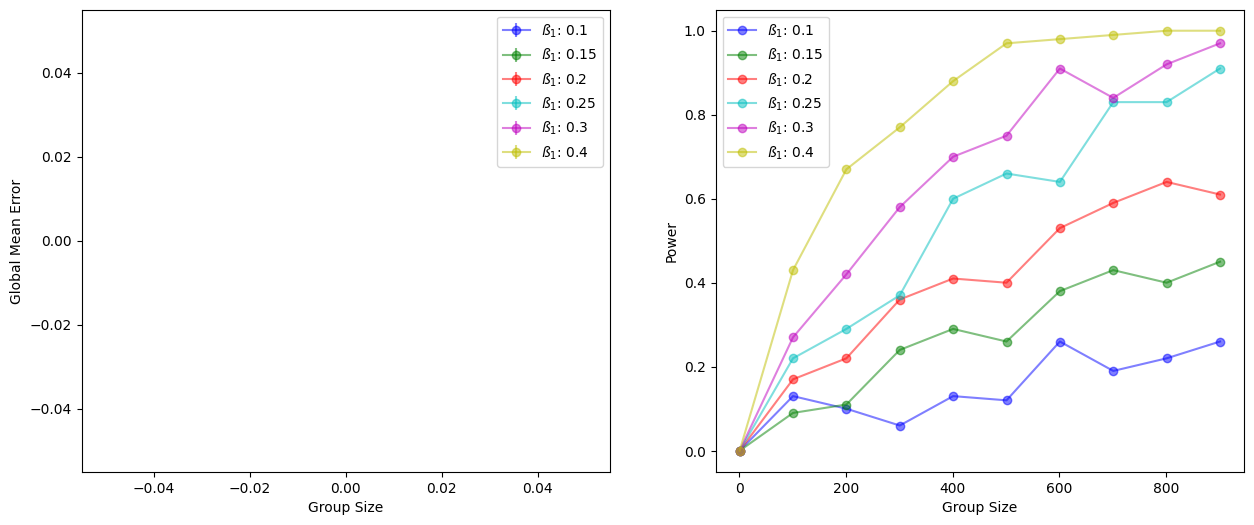

In [6]:
import simulate
import importlib
importlib.reload(simulate)
# set random seed
np.random.seed(123)
# group_size = [x for x in range(1, 501, 50)]
# global_err = simulate_no_courses(no_courses = 50, # fix
#                                 no_simulations = 100, 
#                                 no_students = 5500, # fix
#                                 group_size = group_size,   # influencial
#                                 group_offset = [(0.1, -0.1), (0.15, -0.15), (0.2, -0.2), (0.25, -0.25),(0.3, -0.3), (0.4, -0.4), (0.5, -0.5),], # fix
#                                 interpolation = 'linear',
#                                 verbose=True)

group_size = [x for x in range(1, 1001, 100)]

global_err = simulate_no_courses(no_courses = 5, # fix
                                no_simulations = 100, 
                                no_students = 1000, # fix
                                group_size = group_size,   # influencial
                                group_offset = [(0.1, -0.1), (0.15, -0.15), (0.2, -0.2), (0.25, -0.25),(0.3, -0.3), (0.4, -0.4)], # fix
                                interpolation = 'linear',
                                verbose=True,
                                offset = False)

KeyboardInterrupt: 

In [227]:
print(group_ratio[0], global_err[0])

0.002 [0.1684146  0.3731298  0.47361314 0.56933832 0.34602796 0.66666396
 0.68463157 0.37719815 0.54572803 0.4052282  0.19455937 0.1163192
 0.4620694  0.6734697  0.10576369 0.2357444  0.12265203 0.56044806
 0.43449062 0.31233404 0.72735475 0.2866678  0.45206547 0.92207817
 0.19899412 0.08989005 0.13678683 0.74706656 0.17907391 0.7738933
 0.37433787 0.14216462 0.516699   0.20329585 0.51088686 0.70287089
 0.39166859 0.56387146 0.16851815 0.29442698 0.70046156 0.88900934
 0.70331297 0.22704993 0.77079943 0.51878006 0.39767186 0.43848437
 0.29565018 0.69360555 0.68570609 0.37073959 0.12139678 0.40273773
 0.11960035 0.46699275 0.4464024  0.06816654 0.09324909 0.82518916
 0.736373   0.14294663 0.55206338 0.08560029 0.28300241 0.24849604
 0.12566736 0.35878951 0.54997785 0.31695064 0.46009227 0.24598266
 0.12226192 0.56019448 0.48922208 0.75544545 0.27755546 0.45869222
 0.6366855  0.23897271 0.71780806 0.54271147 0.53942392 0.06510932
 0.16542269 0.12348955 0.20910183 0.55330207 0.20821357 0.

(25,) (25,) (25,)


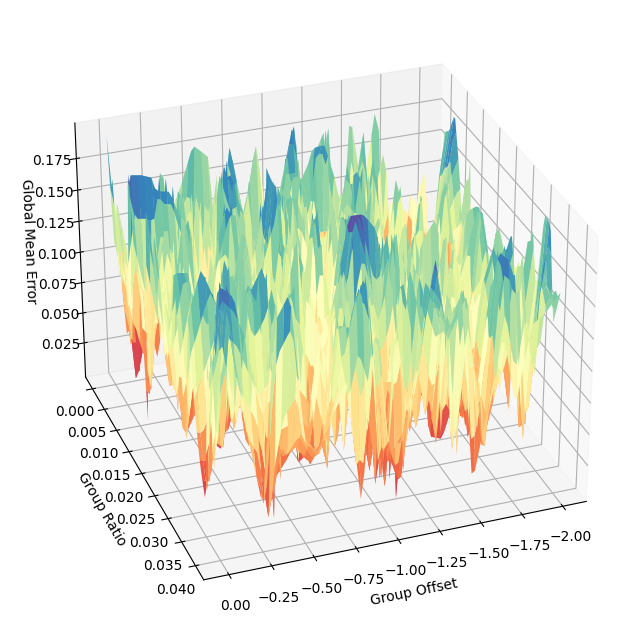

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Since the actual data is not available, I will create some mock data that could resemble what the user has.
# Normally, the user would use the actual data from their 'global_err', 'group_ratio', and 'group_offset' variables.

# Creating mock data for demonstration purposes
# Let's say the 'group_offset' and 'group_ratio' are 1D arrays of length 25 each, and 'global_err' is a 1D array of the same length.
group_offset = np.linspace(-2.0, 0.0, 25)
group_ratio = np.linspace(0.0, 0.04, 25)
global_err = np.random.rand(25) * 0.2  # Random errors between 0 and 0.2

print(group_offset.shape, group_ratio.shape, global_err.shape)

# Create a meshgrid for the 'group_offset' and 'group_ratio'
X, Y = np.meshgrid(group_offset, group_ratio)

# Since 'global_err' is a 1D array, we simulate a corresponding Z value for each (X,Y) pair in the meshgrid.
# In the real scenario, Z would be a 2D array representing the 'global_err' at each (X,Y) pair.
Z = np.random.rand(25, 25) * 0.2  # Random errors in a 2D array

# Interpolate the data to create a smooth surface
# We need to flatten the arrays to pass to 'griddata'
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((X.flatten(), Y.flatten()), Z.flatten(), (xi, yi), method='linear')

# 3D plot
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(xi, yi, zi, cmap='Spectral')

ax.set_xlabel('Group Offset')
ax.set_ylabel('Group Ratio')
ax.set_zlabel('Global Mean Error')
ax.view_init(elev=30, azim=70)

# Show the plot
plt.show()

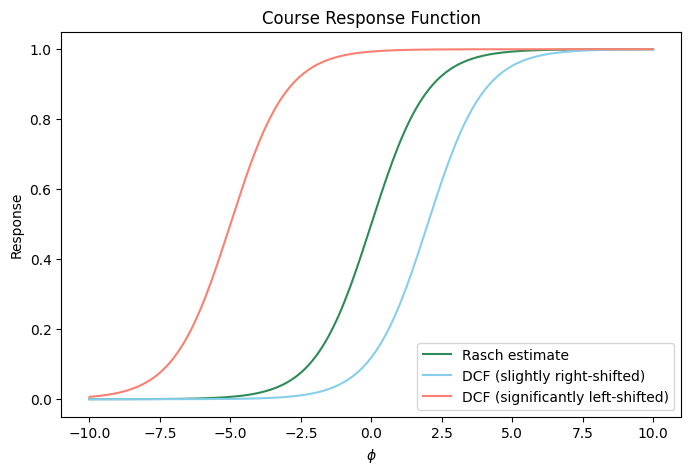

In [93]:
# Adjusting the plot according to the new specifications
# Generating data for the sigmoid function
x = np.linspace(-10, 10, 200)
y = 1 / (1 + np.exp(-x))

# New data for the shifted sigmoids (Differential Course Function - DCF)
x_dcf_right = x - 2  # slightly shifted to the right
y_dcf_right = 1 / (1 + np.exp(-x_dcf_right))

x_dcf_left = x + 5  # significantly shifted to the left
y_dcf_left = 1 / (1 + np.exp(-x_dcf_left))

# Creating the plot with the specified adjustments
plt.figure(figsize=(8, 5))

# Original sigmoid (Rasch estimate)
plt.plot(x, y, label='Rasch estimate', color='seagreen')

# Shifted sigmoids (DCF)
plt.plot(x, y_dcf_right, label='DCF (slightly right-shifted)', color='skyblue')
plt.plot(x, y_dcf_left, label='DCF (significantly left-shifted)', color='salmon')

# Adding titles and labels
plt.title('Course Response Function')
plt.xlabel('$\phi$')
plt.ylabel('Response')

# Other plot settings
plt.grid(False)
plt.legend()
plt.show()

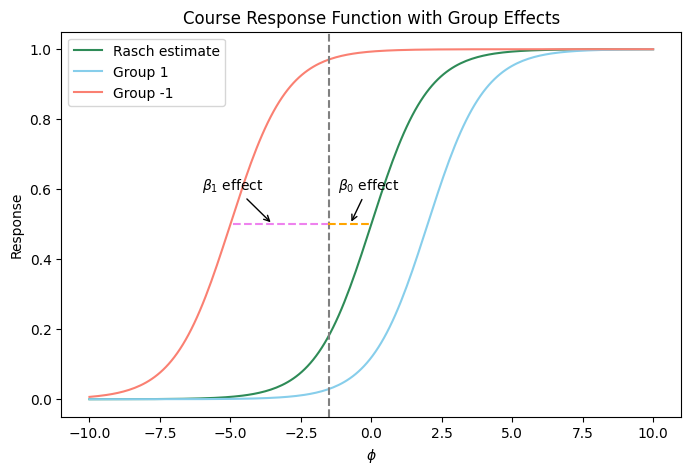

In [94]:
# Replotting the original sigmoids with the additional information about beta_0 and beta_1

# Hypothetical values for beta_0 and beta_1 for demonstration (as before)
beta_0 = -1.5  # mean offset
beta_1 = 1  # effect of being in group 1 vs group -1

# Plotting the original and shifted sigmoids
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='Rasch estimate', color='seagreen')  # Original sigmoid
plt.plot(x, y_dcf_right, label='Group 1', color='skyblue')  # Right-shifted sigmoid
plt.plot(x, y_dcf_left, label='Group -1', color='salmon')  # Left-shifted sigmoid

# Mean position (beta_0)
plt.axvline(x=beta_0, color='grey', linestyle='--')#, label='Mean Offset (β₀)')

# Plot a horizontal line
plt.axhline(y=0.5, xmin= 0.277, xmax= 0.431, color='violet', linestyle='--')

plt.axhline(y=0.5, xmin= 0.431, xmax = 0.5, color='orange', linestyle='--')

# Annotations to show the effect of beta_1
plt.annotate('$β_0$ effect', xy=(beta_0/2 , .5), xytext=(beta_1, 0.6),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')
plt.annotate('$β_1$ effect', xy=(beta_1-9 / 2, 0.5), xytext=(-beta_1-5, 0.6),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='left')

# Adding titles and labels
plt.title('Course Response Function with Group Effects')
plt.xlabel('$\phi$')
plt.ylabel('Response')

# Other plot settings
plt.grid(False)
plt.legend()
plt.show()
